In [735]:
import pandas as pd
import numpy as np
import _pickle
from os.path import join
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import xgboost as xgb
from ggplot import *

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [727]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier,\
GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn import metrics

In [93]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, TomekLinks,\
ClusterCentroids,OneSidedSelection,RandomUnderSampler,\
EditedNearestNeighbours,NeighbourhoodCleaningRule,\
CondensedNearestNeighbour,InstanceHardnessThreshold,\
RepeatedEditedNearestNeighbours

In [460]:
from sklearn.model_selection import GridSearchCV

# 1. Load dataframe and variables

In [411]:
inputfile_path = join('/Users','Toavina','githubdata','12.charting_and_modelling','1.pickles','merged_df_concat.pkl')

agg_df = _pickle.load(open(inputfile_path,'rb'))

%matplotlib inline
plt.style.use('ggplot')

pd.options.display.max_columns = 200

# 2. Create Moving Average and Signals to Detect Anomalies

In [ ]:
# for each in all_dfs[0].columns:
#     print(each)

users = agg_df.columns.levels[0]

all_dfs = [agg_df[users[i]] for i in range(len(users))]

for df in tqdm_notebook(all_dfs):
    df['EWMA_6'] = df['AggEventsWeighted'].ewm(span=6).mean()
    df['EWMA_3'] = df['AggEventsWeighted'].ewm(span=3).mean()
    df['diff_6'] = df['AggEventsWeighted'] - df['EWMA_6']
    df['diff_3'] = df['AggEventsWeighted'] - df['EWMA_3']
    df['perc_diff_3'] = df['diff_3'] / df['EWMA_3']
    df['perc_diff_6'] = df['diff_6'] / df['EWMA_6']

for df in tqdm_notebook(all_dfs):
    
#     EWMA3_Threshold_80 = 0.8
    EWMA6_Threshold_80 = 0.8
      
#     df['EWMA_3_Signal'] = 0
    df['EWMA_6_Signal'] = 0
    
    for j in range(len(df)):
    
#         if df.ix[j,'perc_diff_3'] > EWMA3_Threshold_80:
#             df.ix[j,'EWMA_3_Signal'] = 1

        if df.ix[j,'perc_diff_6'] > EWMA6_Threshold_80:
            df.ix[j,'EWMA_6_Signal'] = 1

# Charting

In [ ]:
def plot_events(usernum):
    
    df = all_dfs[usernum]
    
    min_date = df.index.tolist()[0]
    
    gh_username = df['InferredGHUserCopy'][0]
    
    hn_post_dates = all_dfs[usernum][all_dfs[usernum]['HNPosts'] == 1].index.tolist()
    new_job_dates = all_dfs[usernum][all_dfs[usernum]['NewJobFlag'] == 1].index.tolist()
    end_job_dates = all_dfs[usernum][all_dfs[usernum]['EndJobFlag'] == 1].index.tolist()
    new_edu_dates = all_dfs[usernum][all_dfs[usernum]['StartEduFlag'] == 1].index.tolist()
    end_edu_dates = all_dfs[usernum][all_dfs[usernum]['EndEduFlag'] == 1].index.tolist()
    
    gh_events_series = df['AggEventsWeighted']
    
#     EWMA_3 = df['EWMA_3']
    EWMA_6 = df['EWMA_6']
    
    GH_created_date = all_dfs[usernum]['GHAcctCreatedAt'][0] + pd.offsets.MonthEnd(0, normalize=True)
    
    try:
        plt.axvline(new_edu_dates[0], label = 'New Education')
        [plt.axvline(_x, color='b') for _x in new_edu_dates]
    except:
        pass
    
    try:
        plt.axvline(end_edu_dates[0], label = 'Ended Education')
        [plt.axvline(_x) for _x in end_edu_dates]
    except:
        pass
        
    
    try:
        plt.axvline(hn_post_dates[0], color='b', label = 'HN Job Post')
        [plt.axvline(_x, color='b') for _x in hn_post_dates]
    except:
        pass
    
    if GH_created_date > min_date:
        plt.axvline(GH_created_date, color ='y', label = 'Date GH account created')
    
    try:
        plt.axvline(end_job_dates[0], label = 'Ended Job')
        [plt.axvline(_x) for _x in end_job_dates]
    except:
        pass
    
    try:
        plt.axvline(new_job_dates[0], color='g', label = 'New Job')
        [plt.axvline(_x, color='g') for _x in new_job_dates]
    except:
        pass
    
    gh_events_series.plot(label = "Github Activity (# Events)")
#     EWMA_3.plot(label = "GH Activity EMA_3")
    EWMA_6.plot(label = "GH Activity EMA_6")
    
    plt.legend(bbox_to_anchor=(1.25,0.5), loc = 'lower center', fontsize='small', ncol=1)
    

In [ ]:
plot_events(7)

# Model 1 - Predicting whether someone will switch jobs or not in next 3 / 6 months

In [ ]:
# Create a column that returns 1 if job within the next 3-6 months, 0 if not
# One Hot Encode Relevant Columns, select the relevant ones, and run a RF on it to see baseline results
# Try both 3 and 6 months. When works, see if can create pipeline, do a grid search and run SVM, Linear Regression ...

# Model 2 - Same as above, but qualifying signals as good or bad

# Model 3 - TBD - Create a points system with my knowledge to qualify each signal, see whether machine can find it

# Model 4 - Unlikely - Using points system, score each item and see results versus the machine as to what is a good
# prospect

In [ ]:
def look_fwd_3mo(df,postcolname,newjobcolname):
    
    df['lf_3_job_seeking'] = 0
    
    rows_remaining = len(df)
    
    dates = df.index
    
    for date in dates:
        rows_remaining -= 1
        if rows_remaining >= 3:
            items_to_check = [df.ix[date,postcolname],
                              df.ix[date+1,postcolname],
                              df.ix[date+2,postcolname],
                              df.ix[date+3,postcolname],
                              df.ix[date,newjobcolname],
                              df.ix[date+1,newjobcolname],
                              df.ix[date+2,newjobcolname],
                              df.ix[date+3,newjobcolname]
                             ]
        elif rows_remaining == 2:
            items_to_check = [df.ix[date,postcolname],
                              df.ix[date+1,postcolname],
                              df.ix[date+2,postcolname],
                              df.ix[date,newjobcolname],
                              df.ix[date+1,newjobcolname],
                              df.ix[date+2,newjobcolname]
                             ]
        elif rows_remaining == 1:
            items_to_check = [df.ix[date,postcolname],
                              df.ix[date+1,postcolname],
                              df.ix[date,newjobcolname],
                              df.ix[date+1,newjobcolname]
                             ]
        elif rows_remaining == 0:
            items_to_check = [df.ix[date,postcolname],
                              df.ix[date,newjobcolname]
                             ]
            
        stat_var = 0

        for item in items_to_check:
            if item == 1:
                stat_var = 1
        df.ix[date,'lf_3_job_seeking'] = stat_var
                                      
    return df

for df in tqdm_notebook(all_dfs):
    df = look_fwd_3mo(df,'HNPosts','NewJobFlag')

In [ ]:
# _pickle.dump(all_dfs,open('all_dfs.pkl','wb'))

# Loading the model

In [694]:
all_dfs = _pickle.load(open('all_dfs.pkl','rb'))

In [695]:
all_obs = pd.concat(all_dfs, axis=0)

LinkedInOnly = all_obs[pd.notnull(all_obs['LinkedInName'])]

percentpos = LinkedInOnly['lf_3_job_seeking'].sum()/LinkedInOnly.shape[0]
print('The percentage of positive classifications is {0:.0f}'.format(percentpos))

The percentage of positive classifications is 0


# Separating X and Y, One Hot Encoding...

In [696]:
x = LinkedInOnly[['AggEventsEqual','AggEventsWeighted',
              'JobExpInstitutionType0','JobExpTitleType0',
              'JobExpInstitutionType1','JobExpTitleType1',
              'JobExpInstitutionType2','JobExpTitleType2',
              'JobExpInstitutionType3','JobExpTitleType3',
              'JobExpInstitutionType4','JobExpTitleType4',
              'JobExpInstitutionType5','JobExpTitleType5',
              'EduExpInstitutionType0','EduExpTitleType0',
              'EduExpInstitutionType1','EduExpTitleType1',
              'EduExpInstitutionType2','EduExpTitleType2',
              'EduExpInstitutionType3','EduExpTitleType3',
              'EduExpInstitutionType4','EduExpTitleType4',
#               'JobExpCurrentTenure0','JobExpCurrentTenure1','JobExpCurrentTenure2',
#               'JobExpCurrentTenure3','JobExpCurrentTenure4','JobExpCurrentTenure5',
              'NumCurrentJobs','NumCurrentEdu','NumCurrentJobsAndEdu','EmploymentStatus','NEET',
              'EndJobFlag','StartEduFlag','EndEduFlag','CumJobsToDate','CumEduToDate',
              'HighestDegree','HighestInstitutionType',
#             'HighestDegreeTimeSinceStartDate','HighestDegreeTimeSinceEndDate',
              'RecentJob',
              'RecentJobInstitutionType',
#               'RecentJobTimeSinceStartDate','RecentJobTimeSinceEndDate',
              'GHFollowers','GHFollowing',
#                   'GHHireable',      # Note - Removed because issues with setting to False if nothing
                  'PublicGists','PublicRepos','EWMA_6','EWMA_3','diff_6','diff_3',
              'EWMA_3_Signal','EWMA_6_Signal'
             ]]

In [697]:
y = LinkedInOnly['lf_3_job_seeking']
x = x.reset_index()
y = y.reset_index()

In [698]:
x[[col for col in x.columns if 'JobExpInstitutionType' in col]] = \
x[[col for col in x.columns if 'JobExpInstitutionType' in col]].fillna('none')

x[[col for col in x.columns if 'JobExpTitleType' in col]] = \
x[[col for col in x.columns if 'JobExpTitleType' in col]].fillna('none')

x[[col for col in x.columns if 'EduExpInstitutionType' in col]] = \
x[[col for col in x.columns if 'EduExpInstitutionType' in col]].fillna('none')

x[[col for col in x.columns if 'EduExpTitleType' in col]] = \
x[[col for col in x.columns if 'EduExpTitleType' in col]].fillna('none')

x[[col for col in x.columns if 'NumCurrent' in col]] = \
x[[col for col in x.columns if 'NumCurrent' in col]].fillna(0)

In [699]:
jobexpdummies = pd.concat([pd.get_dummies(x['JobExpInstitutionType{}'.format(str(i))], 
                prefix='JobExpInstitutionType{}'.format(str(i))) for i in range(6)], axis=1)

jobexptitledummies = pd.concat([pd.get_dummies(x['JobExpTitleType{}'.format(str(i))], 
                prefix='JobExpTitleType{}'.format(str(i))) for i in range(6)], axis=1)

eduexpdummies = pd.concat([pd.get_dummies(x['EduExpInstitutionType{}'.format(str(i))], 
                prefix='EduExpInstitutionType{}'.format(str(i))) for i in range(5)], axis=1)

eduexptitledummies = pd.concat([pd.get_dummies(x['EduExpTitleType{}'.format(str(i))], 
                prefix='EduExpTitleType{}'.format(str(i))) for i in range(5)], axis=1)


degreedummies = pd.get_dummies(x['HighestDegree'], prefix='HighestDegree')

highestintitutiontypedummies = pd.get_dummies(x['HighestInstitutionType'], prefix='HighestInstitutionType')

recentjobdummies = pd.get_dummies(x['RecentJob'], prefix = 'RecentJob')
recentjobinstitutiontype = pd.get_dummies(x['RecentJobInstitutionType'], prefix='RecentJobInstitutionType')

x = pd.concat([x,jobexpdummies,jobexptitledummies,eduexpdummies,eduexptitledummies,degreedummies,
          highestintitutiontypedummies,recentjobdummies,recentjobinstitutiontype], axis=1)

In [700]:
x = x.drop([
'index',
'JobExpInstitutionType0',
'JobExpTitleType0',
'JobExpInstitutionType1',
'JobExpTitleType1',
'JobExpInstitutionType2',
'JobExpTitleType2',
'JobExpInstitutionType3',
'JobExpTitleType3',
'JobExpInstitutionType4',
'JobExpTitleType4',
'JobExpInstitutionType5',
'JobExpTitleType5',
'EduExpInstitutionType0',
'EduExpTitleType0',
'EduExpInstitutionType1',
'EduExpTitleType1',
'EduExpInstitutionType2',
'EduExpTitleType2',
'EduExpInstitutionType3',
'EduExpTitleType3',
'EduExpInstitutionType4',
'EduExpTitleType4',
'HighestDegree',
'HighestInstitutionType',
'RecentJob',
'RecentJobInstitutionType'   
        ], axis=1)

In [701]:
y = y.drop('index',axis=1)

# Creating test and train sets

In [702]:
y = np.array(y)

y = y.reshape(y.shape[0],)

In [703]:
# Testing Tree Based feature selection

In [704]:
# clf = RandomForestClassifier()
# clf = clf.fit(x,y)
# model = SelectFromModel(clf, prefit=True)
# X_new = model.transform(x)

In [705]:
pca = PCA(n_components=22)
pca.fit(x)
x = pca.transform(x)

In [706]:
# var1 = np.cumsum(np.round(pca.explained_variance_ratio_,decimals=4)*100)

In [707]:
# print(var1)

In [708]:
# plt.plot(var1)

In [709]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 666)
# X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state = 666)


scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_train.reshape(y_train.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)

sm = SMOTETomek()
X_train, y_train = sm.fit_sample(X_train, y_train)

In [710]:
1- (y_train.sum()/y_train.shape[0])

0.50782190132370641

In [711]:
1- (y_test.sum()/y_test.shape[0])

0.73582337819446542

## 1. Random Forest

In [798]:
rf=RandomForestClassifier(n_jobs = 7, max_features=5,n_estimators=1000)

rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

y_true = y_test

print(accuracy_score(y_true, y_pred),roc_auc_score(y_true, y_pred_proba[:,1]))

0.766974141842 0.785916659197


## 2. XGBoost

In [713]:
# XGBModel = xgb.XGBClassifier(n_estimators=1000, max_depth=10)

# XGBModel.fit(X_train,y_train)

# XGBpreds = XGBModel.predict(X_test)

# print(accuracy_score(y_true,XGBpreds),roc_auc_score(y_true,XGBpreds))

# 5. Extra Trees Classifier

In [833]:
Xtrees = ExtraTreesClassifier(n_jobs=7, 
                              n_estimators=1000, 
                              max_features=5,
                             min_samples_split=3, 
                              criterion='entropy',
                              random_state=123
                             )

Xtrees.fit(X_train,y_train)

XtreePred_proba = Xtrees.predict_proba(X_test)
XtreePreds = Xtrees.predict(X_test)

print(roc_auc_score(y_test,XtreePred_proba[:,1], average='weighted'))

0.79570856128


In [834]:
from sklearn.metrics import precision_score, recall_score

In [842]:
precision_score(y_test, XtreePreds)

0.59910198845413731

In [844]:
recall_score(y_test, XtreePreds)

0.53463079564968519

In [837]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,XtreePreds)

array([[4241,  625],
       [ 813,  934]])

In [801]:
preds = Xtrees.predict_proba(X_test)[:,1]

In [802]:
preds = Xtrees.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_true, preds)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
auc = metrics.auc(fpr,tpr)

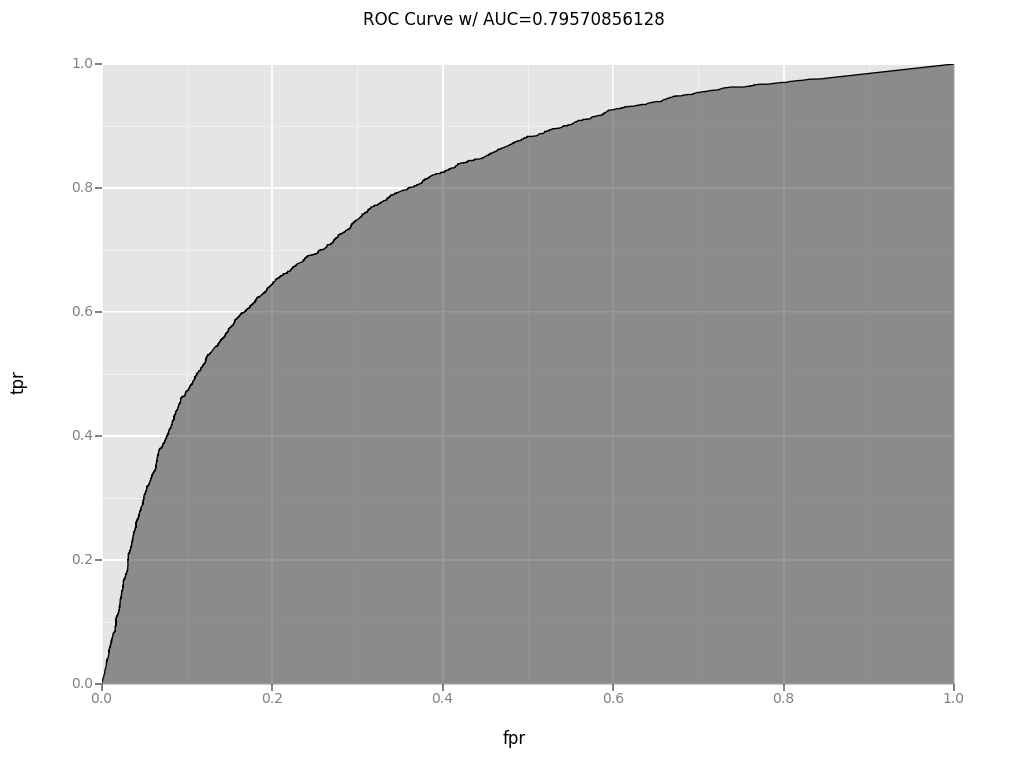

<ggplot: (297437153)>

In [856]:
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_area(alpha=0.5) +\
    geom_line(aes(y='tpr')) +\
    ggtitle("ROC Curve w/ AUC={}".format(str(auc)))

In [730]:
df

,fpr,tpr
0,0.0,1.0
1,1.0,1.0


In [595]:
Xtrees.feature_importances_

array([ 0.04345403,  0.04187088,  0.04166969,  0.03947902,  0.04169332,
        0.04191014,  0.03609763,  0.04146834,  0.04543474,  0.03959846,
        0.03980409,  0.04089975,  0.03908005,  0.03867188,  0.03898282,
        0.03730518,  0.04273846,  0.03884549,  0.03927662,  0.03942067,
        0.03937175,  0.03942535,  0.03735928,  0.03880408,  0.03733828])

# A. Voting Classifier

In [350]:
eclf1 = VotingClassifier(estimators=[
        ('rf',rf),
        ('xtrees',Xtrees)], voting='hard'
    )

In [351]:
eclf1.fit(X_train,y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estim...mators=1000, n_jobs=7, oob_score=False, random_state=None,
           verbose=0, warm_start=False))],
         n_jobs=1, voting='hard', weights=None)

In [352]:
eclfPreds = eclf1.predict(X_test)

In [353]:
print(accuracy_score(y_true,eclfPreds),roc_auc_score(y_true,eclfPreds))

0.780583698775 0.689283796002


In [532]:
params = {'max_depth':[10,20,50,100,200,None],
          'criterion':['entropy'],
         'min_samples_split':[1,2,3,4,5,10],
         'min_samples_leaf':[1,2,3,4,5],
         'max_features':['auto',5],
         'random_state':[123],
          'n_estimators':[5,50,100,1000]
         }
Xtrees = ExtraTreesClassifier()

In [533]:
clf = GridSearchCV(Xtrees, params, n_jobs=7, scoring='roc_auc', cv=2)

In [534]:
clf.fit(X_train,y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=7,
       param_grid={'min_samples_split': [1, 2, 3, 4, 5, 10], 'max_depth': [10, 20, 50, 100, 200, None], 'random_state': [123], 'max_features': ['auto', 5], 'n_estimators': [5, 50, 100, 1000], 'min_samples_leaf': [1, 2, 3, 4, 5], 'criterion': ['entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [542]:
clfPreds = clf.predict(X_test)

In [543]:
print(roc_auc_score(y_true,clfPreds))

0.704650106542


In [544]:
print(accuracy_score(y_true,clfPreds))

0.78375926206


In [545]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1000,
 'random_state': 123}

In [546]:
clf.best_score_

0.9128125160629601